In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

# Download the data
stock = "CVX"
data = yf.download(stock, start="2019-01-01", end=datetime.now().strftime('%Y-%m-%d'))

# Calculate new features
data['Daily Change'] = data['Close'].pct_change()  # Daily Percentage Change
data['Smoothed Daily Change'] = data['Daily Change'].rolling(window=15).mean()
data['5-Day MA'] = data['Close'].rolling(window=5).mean()  # 5-Day Moving Average
data['10-Day MA'] = data['Close'].rolling(window=10).mean()  # 10-Day Moving Average
data['RSI'] = data['Close'].diff().apply(lambda x: np.where(x > 0, x, 0)).rolling(window=14).mean() / \
              data['Close'].diff().abs().rolling(window=14).mean() * 100  # RSI

# Filling NaN values by Back Filling
data['Daily Change'].fillna(method='bfill', inplace=True)
data['Smoothed Daily Change'].fillna(method='bfill', inplace=True)
data['5-Day MA'].fillna(method='bfill', inplace=True)
data['10-Day MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Smoothed Daily Change', '5-Day MA', '10-Day MA', 'Close', 'Volume', 'RSI']])


# Function to create a dataset for predicting the next N days given the last M days
def create_dataset(data, look_back, forecast_horizon):
    X, Y = [], []
    for i in range(len(data) - look_back - forecast_horizon):
        X.append(data[i:(i+look_back), :])  # M days of features
        Y.append(data[(i+look_back):(i+look_back+forecast_horizon), 3])  # Predict next N days close prices
    return np.array(X), np.array(Y)

# Define the parameters for look-back and forecasting
time_steps = 60  # Number of time steps in the input data
forecast_horizon = 1  # Next x days to predict
features = 6

# Create dataset for training and testing
X, y = create_dataset(scaled_data, time_steps, forecast_horizon)

# Use some percentage of data for training
threshold = int(np.ceil(len(X) * 0.9))
X_train, y_train = X[:threshold], y[:threshold]
X_test, y_test = X[threshold:], y[threshold:]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], time_steps, features)  # 5 is the number of features
X_test = X_test.reshape(X_test.shape[0], time_steps, features)

# Print shapes of the datasets
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)


[*********************100%%**********************]  1 of 1 completed

Training data shape: (1155, 60, 6)
Training labels shape: (1155, 1)
Testing data shape: (128, 60, 6)
Testing labels shape: (128, 1)


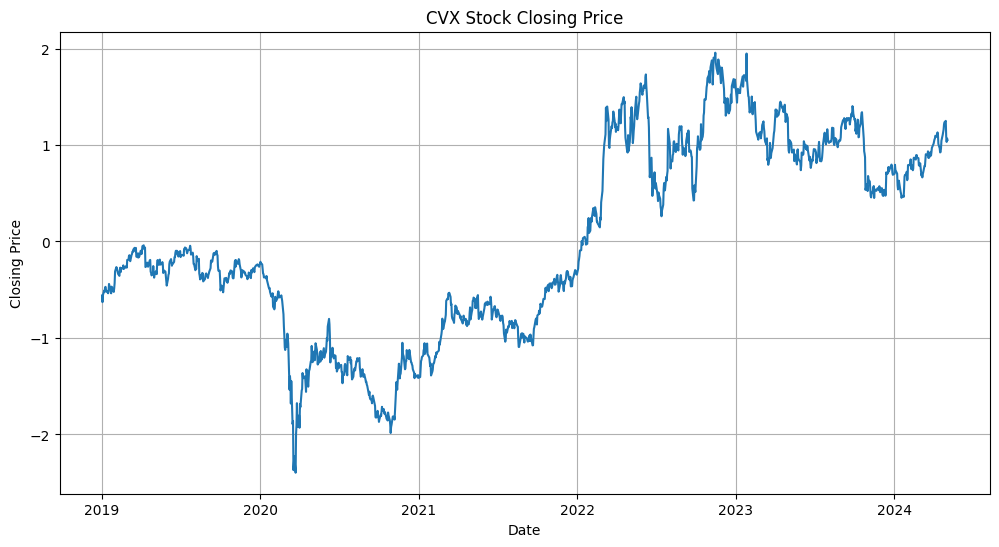

In [2]:
import matplotlib.pyplot as plt

closing_data=scaled_data.T[3]

plt.figure(figsize=(12,6))
plt.plot(data.index, closing_data)
plt.title(f'{stock} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid()
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Constants
latent_dim = 20  # Dimension of the latent space
epsilon_std = 1.0  # Standard deviation for the Gaussian noise

# Encoder
def build_encoder():
    inputs = Input(shape=(time_steps, features), name='encoder_input')
    h = LSTM(128)(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(h)
    z_log_sigma = Dense(latent_dim, name='z_log_sigma')(h)

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z_sampling')([z_mean, z_log_sigma])
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
    return encoder

# Adjusted Decoder for Prediction
def build_decoder():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = RepeatVector(forecast_horizon)(latent_inputs)  # Outputs repeated over the forecast horizon
    x = LSTM(128, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(features))(x)  # Outputs features at each forecasted time step
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

encoder = build_encoder()
decoder = build_decoder()

# VAE Model
inputs = Input(shape=(time_steps, features), name='encoder_input')
z_mean, z_log_sigma, z = encoder(inputs)
outputs = decoder(z)

vae = Model(inputs, outputs, name='vae_mlp')

# Loss Functions
reconstruction_loss = tf.reduce_mean(tf.square(inputs[:, -forecast_horizon:, :] - outputs))  # Focus on the last steps matching the forecast
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=-1)
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)

vae.compile(optimizer=Adam(learning_rate=0.001))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
vae.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
37/37 [==============================] - 8s 100ms/step - loss: 0.9427 - val_loss: 0.4903
Epoch 2/100
37/37 [==============================] - 2s 63ms/step - loss: 0.6668 - val_loss: 0.4286
Epoch 3/100
37/37 [==============================] - 2s 62ms/step - loss: 0.5571 - val_loss: 0.4207
Epoch 4/100
37/37 [==============================] - 3s 94ms/step - loss: 0.5163 - val_loss: 0.3984
Epoch 5/100
37/37 [==============================] - 2s 61ms/step - loss: 0.4754 - val_loss: 0.3918
Epoch 6/100
37/37 [==============================] - 5s 127ms/step - loss: 0.4557 - val_loss: 0.3688
Epoch 7/100
37/37 [==============================] - 6s 169ms/step - loss: 0.4316 - val_loss: 0.3970
Epoch 8/100
37/37 [==============================] - 3s 92ms/step - loss: 0.4299 - val_loss: 0.3653
Epoch 9/100
37/37 [==============================] - 3s 73ms/step - loss: 0.4211 - val_loss: 0.3336
Epoch 10/100
37/37 [==============================] - 4s 121ms/step - loss: 0.4073 - val_loss: 0.

In [ ]:
import matplotlib.pyplot as plt

# Predicting the outputs for the test data
predicted_outputs = vae.predict(X_test)
predicted_close_prices = predicted_outputs[:, 0, 3]

In [ ]:
# Start the autoregressive loop using the last X days of training data
init = X_train[-1].reshape(1, time_steps, features)  # Reshape for the model input

# Initialize predictions list
future_predictions = []

# Simulate for a specified number of days

for _ in range(30):
    # Predict the next day's price
    # shape = (1, 1, 5)
    next_day_prediction = vae.predict(init)

    # Append prediction
    future_predictions.append(next_day_prediction.flatten())  # Flatten if the model outputs more dimensions

    # Update the last_30_days to include the new prediction
    new_day = next_day_prediction.reshape(1, 1, features)  # Ensure the shape aligns with the LSTM input
    init = np.append(init[:, 1:, :], new_day, axis=1)  # Slide window

# Convert predictions to a numpy array
future_predictions = np.array(future_predictions)


plt.figure(figsize = (12,6))
plt.plot(y_test, label='Actual Close Prices')
plt.plot(future_predictions[:,3][::-1], label='Forecast', linestyle='--')
plt.plot(predicted_close_prices, label='Guided', linestyle='--')
plt.title(f'{stock} Comparison of Actual and Predicted Close Prices: VAE')
plt.ylabel('Normalized Price')
plt.legend()
plt.xlabel('Time Step')
plt.tight_layout()
plt.show()


In [ ]:
print(f"MSE: {np.mean((predicted_close_prices - y_test)**2)}")

In [ ]:
print(f"MSE: {np.mean((future_predictions[:,3][::-1] - y_test[:30])**2)}")